Oct 12th 2025

## Objective:
Use previously pre-processed data and fit a suite of classification models in a modular pipeline. The models chosen are logistic regression, Decision Tree and Random Forest. Optimise all 3 models for hyperparamters and evaluate performance using ROC-AUC curve and accuracy. Finally write the optimized model objects in artifacts.

## Setup

In [101]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, KFold, cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import KNNImputer
from sklearn.metrics import RocCurveDisplay, accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

## Loading pre-processed data

In [5]:
path_to_dataset = r'C:\\\\Users\\\\patil\\\\Documents\\\\GitHub\\\\ml_projects\\\\heart_disease_prediction\\\\data\\\\processed'
filename = 'processed_data.csv'
full_file_path = os.path.join(path_to_dataset, filename)
df = pd.read_csv(full_file_path, index_col=False)

In [6]:
df

,age,sex,trestbps,chol,fbs,thalch,exang,oldpeak,ca,num,...,cp_typical angina,restecg_lv hypertrophy,restecg_normal,restecg_st-t abnormality,slope_downsloping,slope_flat,slope_upsloping,thal_fixed defect,thal_normal,thal_reversable defect
0,63,1,145.0,233.0,1,150.0,0,2.3,0.0,0,...,1,1,0,0,1,0,0,1,0,0
1,67,1,160.0,286.0,0,108.0,1,1.5,3.0,1,...,0,1,0,0,0,1,0,0,1,0
2,67,1,120.0,229.0,0,129.0,1,2.6,2.0,1,...,0,1,0,0,0,1,0,0,0,1
3,37,1,130.0,250.0,0,187.0,0,3.5,0.0,0,...,0,0,1,0,1,0,0,0,1,0
4,41,0,130.0,204.0,0,172.0,0,1.4,0.0,0,...,0,1,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,54,0,127.0,333.0,1,154.0,0,0.0,NaN,1,...,0,0,0,1,0,1,0,0,1,0
916,62,1,NaN,139.0,0,NaN,1,NaN,NaN,0,...,1,0,0,1,0,1,0,0,0,1
917,55,1,122.0,223.0,1,100.0,0,0.0,NaN,1,...,0,0,0,1,0,1,0,1,0,0
918,58,1,NaN,385.0,1,NaN,0,NaN,NaN,0,...,0,1,0,0,0,1,0,0,0,1


In [10]:
x = df.drop('num', axis = 1)
x = x.to_numpy()
x.shape

(920, 22)

In [11]:
y = df['num'].to_numpy()
y.shape

(920,)

##  Logistic Regression

### Fit the model

In [46]:
scaler = StandardScaler()
imputer = KNNImputer(n_neighbors=3)
model = LogisticRegression(random_state=42)
kf = KFold(n_splits = 4, shuffle = True, random_state = 42)

In [47]:
pipeline = Pipeline(steps = [('imputer', imputer), ('scaler', scaler), ('classifier', model)])

In [48]:
scores = cross_validate(estimator=pipeline, X=x, y=y, cv=kf, scoring='accuracy', return_train_score = True)

In [51]:
scores['train_score'].mean(), scores['test_score'].mean()

(0.8123188405797102, 0.7967391304347826)

### ROC curve for Logistic Regression
For ROC, we need to do train test split (cross val has 4 splits and ROC curve needs only 1 training and testing set

In [53]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, shuffle=True)

In [55]:
pipeline = Pipeline(steps = [('imputer', imputer), ('scaler', scaler), ('classifier', model)])
pipeline.fit(x_train, y_train)

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=3)),
                ('scaler', StandardScaler()),
                ('classifier', LogisticRegression(random_state=42))])

In [58]:
y_pred = pipeline.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy

0.8130434782608695

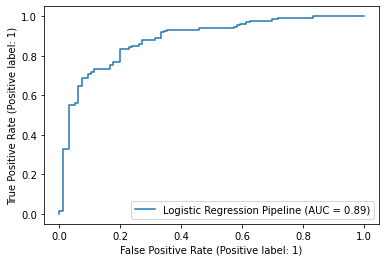

In [89]:
# plt.figure(figsize= (15,7.5))

roc_display = RocCurveDisplay.from_estimator(estimator=pipeline, X = x_test, y = y_test, name= 'Logistic Regression Pipeline')

In [82]:
y_pred = pipeline.predict_proba(x_test)[:, 1]

In [93]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('ROC AUC is ',roc_auc)

ROC AUC is  0.8852611940298508


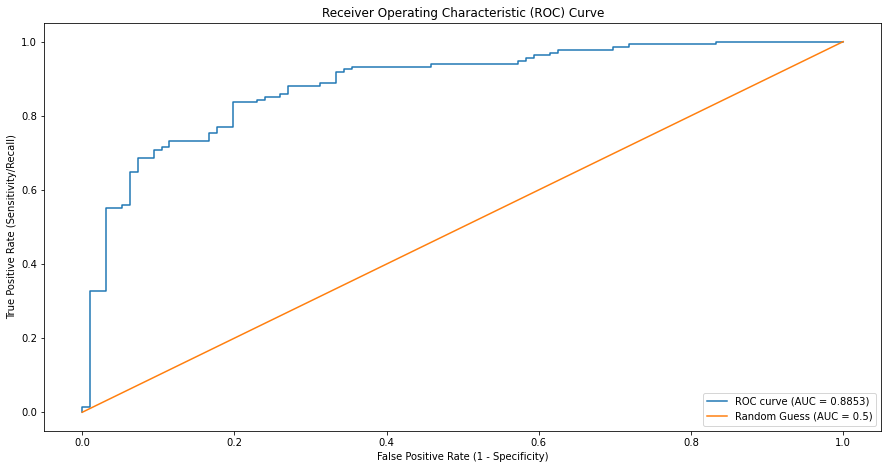

In [88]:
plt.figure(figsize=(15,7.5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0,1],[0,1], label='Random Guess (AUC = 0.5)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

In [91]:
curve = pd.DataFrame(data = {'fpr': fpr,'tpr':tpr, 'threshold':thresholds})
curve['dist_to_optimal'] = np.sqrt((curve['fpr'] - 0)**2 + (curve['tpr'] - 1)**2)
curve

,fpr,tpr,threshold,dist_to_optimal
0,0.000000,0.000000,inf,1.000000
1,0.000000,0.007463,0.983201,0.992537
2,0.000000,0.014925,0.980756,0.985075
3,0.010417,0.014925,0.976241,0.985130
4,0.010417,0.328358,0.908645,0.671723
5,0.031250,0.328358,0.901716,0.672368
6,0.031250,0.552239,0.777963,0.448850
7,0.052083,0.552239,0.772673,0.450780
8,0.052083,0.559701,0.768315,0.443368
9,0.062500,0.559701,0.763956,0.444712


In [95]:
curve['dist_to_optimal'].idxmin()

24

In [97]:
ideal_threshold = curve.loc[24]
ideal_threshold

fpr                0.197917
tpr                0.835821
threshold          0.493885
dist_to_optimal    0.257149
Name: 24, dtype: float64

### Predict with the best threshold value
Although the threshold here is not very different from 0.5 (standard)

In [99]:
y_prob = pipeline.predict_proba(x_test)[:,1]
y_pred_opt_threshold = (y_prob >= ideal_threshold['threshold'])
test_accuracy = accuracy_score(y_test, y_pred_opt_threshold)
test_accuracy

0.8217391304347826

### Plot the confusion matrix

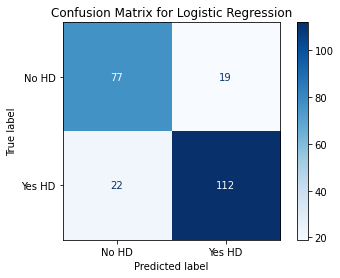

In [102]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_opt_threshold, 
    cmap=plt.cm.Blues,
    display_labels=['No HD', 'Yes HD'],
    normalize=None # Set to 'true', 'pred', or 'all' to normalize the counts
)

disp.ax_.set_title('Confusion Matrix for Logistic Regression')
plt.show()

Performance metrics:
1. Sensitivity (Recall): 83.5%
2. Specificity: 80.2%
3. Precision: 85.5%
4. Accuracy: 82.17%

### Reflections on Logistic Regression

Cross val gave a test accuracy of 79.6%, which is more robust, however when test-train split was done the accuracy changed to 81.3% which is a minor change (shuffle was True for both cases as this is not randomly ordered dataset). We then drew the ROC AUC curve (AUC is 0.88) and found the ideal threshold (which was very close to 0.5) changing the predictions by switching threshold to ideal further improved the accuracy to 82.17%. We will compare this with other classification models.